## Import Header

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.layers import RandomZoom, RandomRotation

from tensorflow.keras.applications import resnet_v2, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

def unzip(nm):
	with ZipFile("archive.zip","r") as zip:
		zip.extractall()

unzip("archive.zip")

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"TB_Chest_Radiography_Database",
	validation_split = 0.2,
	subset = "training",
	seed = 1337,
	shuffle = True,
	image_size = (224,224),
	batch_size = 32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"TB_Chest_Radiography_Database",
	validation_split = 0.2,
	subset = "validation",
	seed = 1337,
	shuffle = True,
	image_size = (224,224),
	batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


## Plot some images

['Normal', 'Tuberculosis']


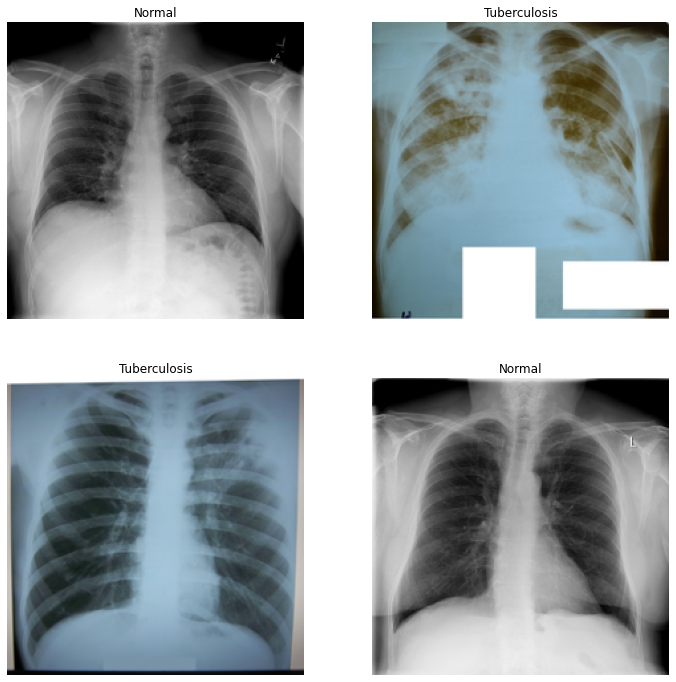

In [4]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
	for i in range(4):
		ax = plt.subplot(2,2,i+1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Define the model (Transfer learning feature extraction)

In [5]:
data_augmentation = tf.keras.Sequential([
	RandomZoom(0.2),
	RandomRotation(0.1),
])

rescale = resnet_v2.preprocess_input

base_model = ResNet50V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = False
base_model.summary()


class Transfer_ResNet50V2():
	def model(self,input):
		self.x = data_augmentation(input)
		self.x = rescale(self.x)
		self.x = base_model(self.x,training=False)
		self.x = GlobalAveragePooling2D()(self.x)
		self.x = Dropout(0.2,seed=1337)(self.x)
		self.outputs = Dense(2,activation="sigmoid")(self.x)
		self.model = Model(input,self.outputs,name="Transfer_ResNet50V2")
		return self.model

T = Transfer_ResNet50V2()
model = T.model(Input(shape=(224,224,3)))
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "Transfer_ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)      

In [6]:
if __name__=="__main__":
	loss0,accuracy0 = model.evaluate(val_ds)
	print("Initial loss: {:.2f} %".format(100*loss0))
	print("Initial accuracy: {:.2f} %".format(100*accuracy0))
	checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
	model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[checkpoint])
	best = load_model("tuberculosis.hdf5")
	val_loss,val_accuracy = best.evaluate(val_ds)
	test_loss,test_accuracy = best.evaluate(test_ds)
	print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
	print("Val loss: {:.2f} %".format(100*val_loss))
	print("\nTest accuracy: {:.2f} %".format(100*test_accuracy))
	print("Test loss : {:.2f} %".format(100*test_loss))

22/22 [==============================] - 8s 193ms/step - loss: 1.7343 - accuracy: 0.1824
Initial loss: 173.43 %
Initial accuracy: 18.24 %
Epoch 1/10
105/105 [==============================] - 23s 199ms/step - loss: 0.2744 - accuracy: 0.8991 - val_loss: 0.1428 - val_accuracy: 0.9412


/home/maverick/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
105/105 [==============================] - 21s 200ms/step - loss: 0.1517 - accuracy: 0.9464 - val_loss: 0.0850 - val_accuracy: 0.9706
Epoch 3/10
105/105 [==============================] - 21s 201ms/step - loss: 0.1130 - accuracy: 0.9574 - val_loss: 0.0966 - val_accuracy: 0.9574
Epoch 4/10
105/105 [==============================] - 21s 201ms/step - loss: 0.1051 - accuracy: 0.9628 - val_loss: 0.0758 - val_accuracy: 0.9691
Epoch 5/10
105/105 [==============================] - 21s 199ms/step - loss: 0.0955 - accuracy: 0.9676 - val_loss: 0.0698 - val_accuracy: 0.9721
Epoch 6/10
105/105 [==============================] - 21s 198ms/step - loss: 0.0752 - accuracy: 0.9711 - val_loss: 0.0748 - val_accuracy: 0.9691
Epoch 7/10
105/105 [==============================] - 21s 198ms/step - loss: 0.0765 - accuracy: 0.9717 - val_loss: 0.0594 - val_accuracy: 0.9779
Epoch 8/10
105/105 [==============================] - 21s 198ms/step - loss: 0.0781 - accuracy: 0.9771 - val_loss: 0.0638 - val_ac